<a href="https://colab.research.google.com/github/Pt-home/Notebooks/blob/main/Nomades2_0_Rashid_05(withoutTranningAndBackward).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
# библиотека scipy.special содержит сигмоиду expit()
import scipy.special
import matplotlib.pyplot
%matplotlib inline

In [11]:
# определение класса нейронной сети class neuralNetwork:
class neuralNetwork:

  def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate) :
    # задать количество узлов во входном, скрытом и выходном слое
    self.inodes = inputnodes
    self.hnodes = hiddennodes
    self.onodes = outputnodes

    # коэффициент обучения
    self.lr = learningrate

    #матрицы весов
    self.wih = numpy.random.rand(self.hnodes, self.inodes) - 0.5
    self.who = numpy.random.rand(self.onodes, self.hnodes) - 0.5

    # использование сигмоиды в качестве функции активации
    self.activation_function = lambda x: scipy.special.expit(x)
    #обратная активация
    self.inverse_activation_function = lambda x: scipy.special.logit(x)

  def train(self, inputs_list, targets_list):

    # Прямой проход

    # преобразовать список входных значений в двухмерный массив
    inputs =  numpy.array(inputs_list, ndmin = 2).T
    targets = numpy.array(targets_list, ndmin = 2).T

    # рассчитать входящие сигналы для скрытого слоя
    hidden_inputs = numpy.dot(self.wih, inputs)
    # рассчитать исходящие сигналы для скрытого слоя
    hidden_outputs = self.activation_function(hidden_inputs)

    # рассчитать входящие сигналы для выходного слоя
    final_inputs = numpy.dot(self.who, hidden_outputs)
    # рассчитать исходящие сигналы для выходного слоя
    final_outputs = self.activation_function(final_inputs)

    # Анализ и коррекция весов

    # ошибка = целевое значение - фактическое значение
    output_errors = targets - final_outputs

    # ошибки скрытого слоя - это ошибки output_errors, распределенные пропорционально весовым коэффициентам связей и рекомбинированные на скрытых узлах
    hidden_errors = numpy.dot(self.who.T, output_errors)

    # обновить весовые коэффициенты связей между скрытым и выходным слоями
    self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
    # обновить весовые коэффициенты связей между входным и скрытым слоями
    self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

  def query(self, inputs_list):
    # преобразовать список входных значений в двухмерный массив
    inputs = numpy.array(inputs_list, ndmin = 2).T

    # рассчитать входящие сигналы для скрытого слоя
    hidden_inputs = numpy.dot(self.wih, inputs)
    # рассчитать исходящие сигналы для скрытого слоя
    hidden_outputs = self.activation_function(hidden_inputs)

    # рассчитать входящие сигналы для выходного слоя
    final_inputs = numpy.dot(self.who, hidden_outputs)
    # рассчитать исходящие сигналы для выходного слоя
    final_outputs = self.activation_function(final_inputs)

    return final_outputs

  def backquery(self, targets_list):
     # transpose the targets list to a vertical array
     final_outputs = numpy.array(targets_list, ndmin=2).T

     # calculate the signal into the final output layer
     final_inputs =  self.inverse_activation_function(final_outputs)

     # calculate the signal out of the hidden layer
     hidden_outputs = numpy.dot(self.who.T, final_inputs)

     # scale them back to 0.01 to .99
     hidden_outputs -= numpy.min(hidden_outputs)
     hidden_outputs /= numpy.max(hidden_outputs)
     hidden_outputs *= 0.98
     hidden_outputs += 0.01

     # calculate the signal into the hidden layer
     hidden_inputs = self.inverse_activation_function(hidden_outputs)

     # calculate the signal out of the input layer
     inputs = numpy.dot(self.wih.T, hidden_inputs)

     # scale them back to 0.01 to .99
     inputs -= numpy.min(inputs)
     inputs /= numpy.max(inputs)
     inputs *= 0.98
     inputs += 0.01

     return inputs

In [12]:
# количество входных, скрытых и выходных узлов
input_nodes = 784
hidden_nodes = 200
output_nodes = 10
# коэффициент обучения равен 0,1
learning_rate = 0.1

epochs = 5

In [13]:
# создать экземпляр нейронной сети
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [14]:
# загрузить cеть
f = open('wih_' + str(hidden_nodes) + '_' + str(learning_rate) + '_' + str(epochs) + '.dat','r')
record = f.readlines()[0].split(',')
n.wih = numpy.asfarray(record).reshape(n.hnodes, n.inodes)
n.wih.shape

(200, 784)

In [15]:
f = open('who_' + str(hidden_nodes) + '_' + str(learning_rate) + '_' + str(epochs) + '.dat','r')
record = f.readlines()[0].split(',')
n.who = numpy.asfarray(record).reshape(n.onodes, n.hnodes)
n.who.shape

(10, 200)

In [16]:
# загрузить в список тестовый набор данных CSV-файла набора MNIST
test_data_file = open("mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [17]:
# тестирование нейронной сети

# журнал оценок работы сети, первоначально пустой
scorecard = []
# перебрать все записи в тестовом наборе данных
for record in test_data_list:

  # получить список значений, используя символы запятой (1,1) в качестве разделителей
  all_values = record.split(",")
  # масштабировать и сместить входные значения
  inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

  outputs = n.query(inputs)

  # индекс наибольшего значения является маркерным значением
  label = numpy.argmax(outputs)
  correct_label = int(all_values[0])

  if correct_label==label:
    scorecard.append(1)
  else:
    scorecard.append(0)

print(f"Эффективность: {sum(scorecard) / len(scorecard)}")

Эффективность: 0.9713


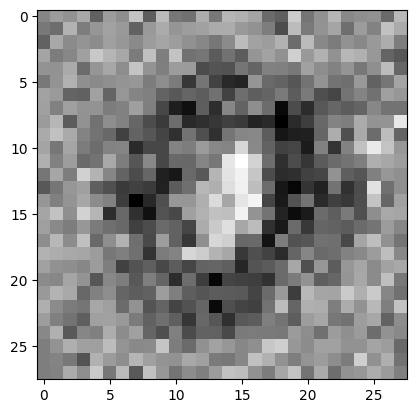

In [19]:
# label to test
label = 0

# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

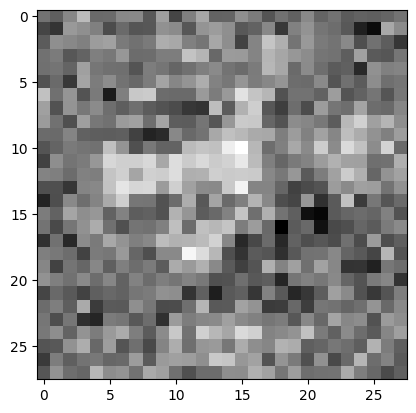

In [20]:
# label to test
label = 1

# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

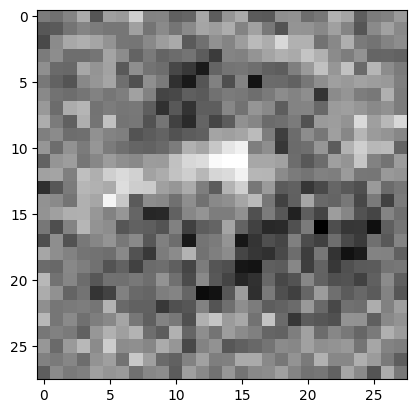

In [21]:
# label to test
label = 2

# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

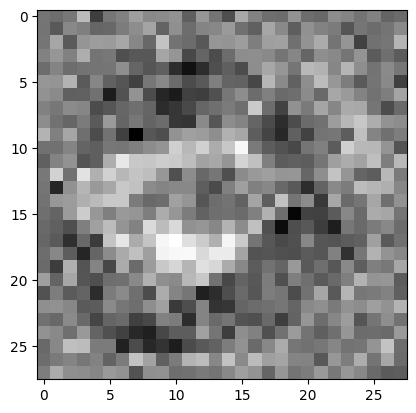

In [22]:
# label to test
label = 3

# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

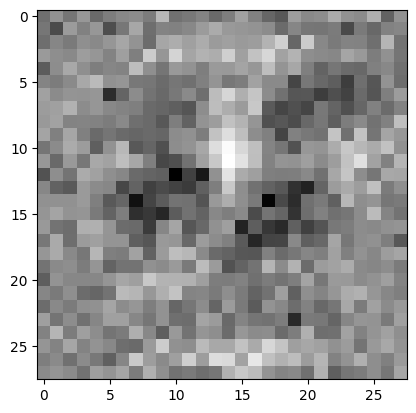

In [23]:
# label to test
label = 4

# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

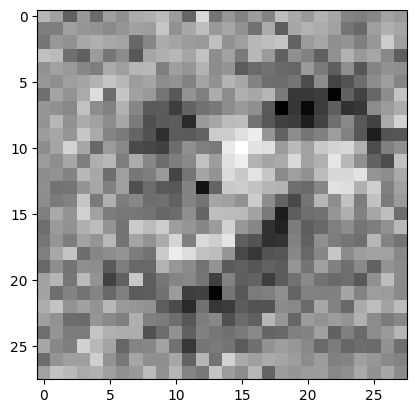

In [24]:
# label to test
label = 5

# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

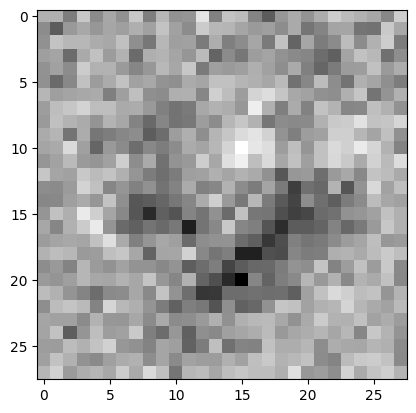

In [25]:
# label to test
label = 6

# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

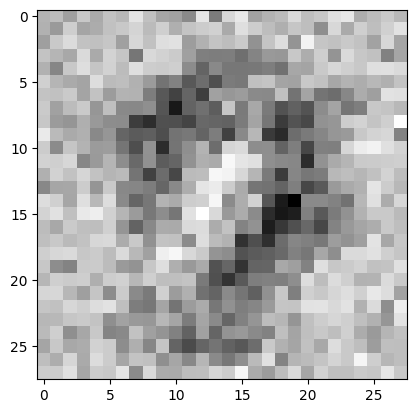

In [26]:
# label to test
label = 7

# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

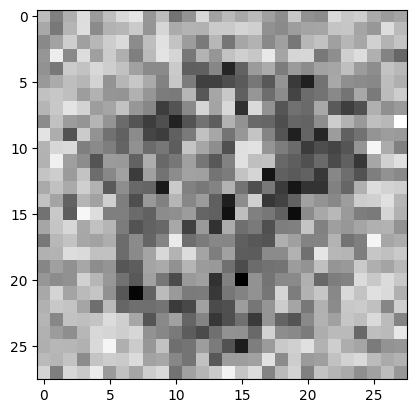

In [27]:
# label to test
label = 8

# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

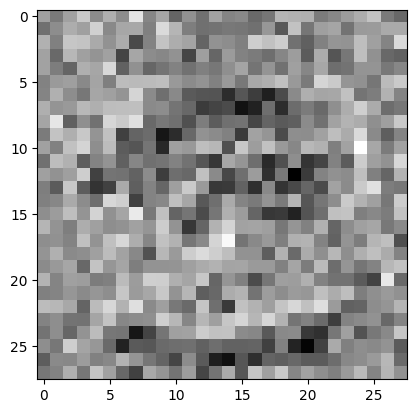

In [28]:
# label to test
label = 9

# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')